# Segmenting and Clustering Neighborhoods in Toronto


In [125]:
!pip install folium
!pip install requests_html
!pip install geopy
import requests
import folium
import requests_html
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import pandas as pd
import numpy as np
# import k-means from clustering stage
from sklearn.cluster import KMeans


# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

!pip install geocoder
import geocoder

     |████████████████████████████████| 102kB 5.9MB/s 


### 1. Use the Notebook to build the code to scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas  dataframe like the one shown below:
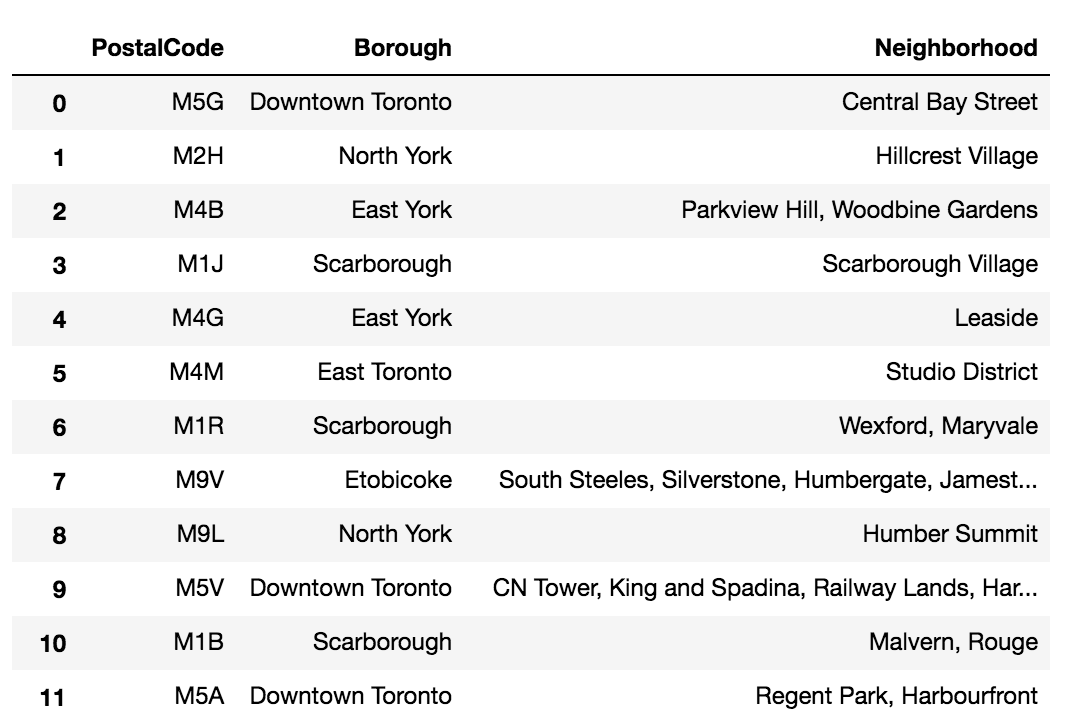

first using requests_html library to get the neighborhood list of Toronro.

In [135]:
wikipage_url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

# use requests_html and Xpath to get the table body
Session = requests_html.HTMLSession()
wiki_page = Session.get(wikipage_url)
Neighbour_tbdy = wiki_page.html.xpath('//*[@id="mw-content-text"]/div[1]/table[1]/tbody')
all_tr_elmts = Neighbour_tbdy[0].find("tbody tr")[1:]


columns_name = ['PostalCode', 'Borough', 'Neighborhood']
all_neighbourhoods = pd.DataFrame(columns=columns_name)
for tr in all_tr_elmts:
  PostalCode = tr.find('td')[0].text
  Borough = tr.find('td')[1].text
  Neighborhood = tr.find('td')[2].text
  if Borough != "Not assigned":
    if Neighborhood != "Not assigned":
      all_neighbourhoods =  all_neighbourhoods.append({'PostalCode':PostalCode, 'Borough':Borough, 'Neighborhood':Neighborhood}, ignore_index=True)
    else:
      all_neighbourhoods =  all_neighbourhoods.append({'PostalCode':PostalCode, 'Borough':Borough, 'Neighborhood':Borough}, ignore_index=True)
      print(PostalCode,Borough,Neighborhood)
    # print(PostalCode,Borough,Neighborhood)

all_neighbourhoods.head()


,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"




---
Submission of quiz 1.

---





In [122]:
# print the shape of all_neighbourhoods
all_neighbourhoods.shape

(103, 3)

## 2. Get the latitude and the longitude coordinates of each neighborhood. 

In [155]:
import geocoder

def get_geocoder(postal_code_from_df):
  # initialize your variable to None
  g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code_from_df))
  latitude = g.json['lat']
  longitude = g.json['lng']
  return latitude,longitude
get_geocoder("M3A")

(43.75245000000007, -79.32990999999998)

In [159]:
# add 2 column first.
try:
  all_neighbourhoods.insert(all_neighbourhoods.shape[1], 'Latitude', 0)
  all_neighbourhoods.insert(all_neighbourhoods.shape[1], 'Longitude', 0)
except:
  pass
for index, row in all_neighbourhoods.iterrows():

  try:
    address = '{}'.format(row['PostalCode'])
    lat, lng = get_geocoder(address)
    all_neighbourhoods.loc[index, 'Latitude'] = lat
    all_neighbourhoods.loc[index, 'Longitude'] = lng
  except:
    print(row['PostalCode'])
  

all_neighbourhoods.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.75245,-79.32991
1,M4A,North York,Victoria Village,43.73057,-79.31306
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188




---
Submission of quiz 2.

---



## 1. Explore Neighbourhood Data in Toronato

In [191]:
print(all_neighbourhoods.shape)
all_neighbourhoods.head()

(103, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.75245,-79.32991
1,M4A,North York,Victoria Village,43.73057,-79.31306
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188


#### Create a map of Tornoto with neighborhoods superimposed on top.


In [161]:
# create map of Toronto using latitude and longitude values
address = 'Toronto'
geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Tornoto are {}, {}.'.format(latitude, longitude))
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(all_neighbourhoods['Latitude'], all_neighbourhoods['Longitude'], all_neighbourhoods['Neighborhood']):
      label = '{}'.format(neighborhood)
      label = folium.Popup(label, parse_html=True)
      folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='red',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_toronto)
    
map_toronto

The geograpical coordinate of Tornoto are 43.6534817, -79.3839347.


In [198]:
CLIENT_ID = '2CVJW11GUA2AEW4LWAVW3JTS4ENBWIAHY0VAIPCNSAJASZFB' # your Foursquare ID
CLIENT_SECRET = 'P1QBMHSSK21VECMSBOMXOSLAPJ4PBIKHR1V3XHPFZKHHQYEW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value


def getNearbyVenues(poscode, latitudes, longitudes, radius=500):
  venues_list=[]
  for poscode, lat, lng in zip(poscode, latitudes, longitudes):
      print(poscode, end='-')
      # create the API request URL
      url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
          CLIENT_ID, 
          CLIENT_SECRET, 
          VERSION, 
          lat, 
          lng, 
          radius, 
          LIMIT)
          
      # make the GET request
      results = requests.get(url).json()["response"]['groups'][0]['items']
      
      # return only relevant information for each nearby venue
      venues_list.append([(
          poscode, 
          lat, 
          lng, 
          v['venue']['name'], 
          v['venue']['location']['lat'], 
          v['venue']['location']['lng'],  
          v['venue']['categories'][0]['name']) for v in results])

  nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
  nearby_venues.columns = ['PostalCode', 
                'Latitude', 
                'Longitude', 
                'Venue', 
                'Venue Latitude', 
                'Venue Longitude', 
                'Venue Category']
  
  return(nearby_venues)

In [199]:
toronto_venues = getNearbyVenues(poscode=all_neighbourhoods['PostalCode'],
                latitudes=all_neighbourhoods['Latitude'],
                longitudes=all_neighbourhoods['Longitude']
              )
print(" ")
print(toronto_venues.shape)
toronto_venues.head()

M3A-M4A-M5A-M6A-M7A-M9A-M1B-M3B-M4B-M5B-M6B-M9B-M1C-M3C-M4C-M5C-M6C-M9C-M1E-M4E-M5E-M6E-M1G-M4G-M5G-M6G-M1H-M2H-M3H-M4H-M5H-M6H-M1J-M2J-M3J-M4J-M5J-M6J-M1K-M2K-M3K-M4K-M5K-M6K-M1L-M2L-M3L-M4L-M5L-M6L-M9L-M1M-M2M-M3M-M4M-M5M-M6M-M9M-M1N-M2N-M3N-M4N-M5N-M6N-M9N-M1P-M2P-M4P-M5P-M6P-M9P-M1R-M2R-M4R-M5R-M6R-M7R-M9R-M1S-M4S-M5S-M6S-M1T-M4T-M5T-M1V-M4V-M5V-M8V-M9V-M1W-M4W-M5W-M8W-M9W-M1X-M4X-M5X-M8X-M4Y-M7Y-M8Y-M8Z-(2381, 7)


,PostalCode,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M3A,43.75245,-79.32991,Brookbanks Park,43.751976,-79.332140,Park
1,M3A,43.75245,-79.32991,Brookbanks Pool,43.751389,-79.332184,Pool
2,M3A,43.75245,-79.32991,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,M3A,43.75245,-79.32991,KFC,43.754387,-79.333021,Fast Food Restaurant
4,M4A,43.73057,-79.31306,Wigmore Park,43.731023,-79.310771,Park


Let's check how many venues were returned for each neighborhood

In [200]:
toronto_venues.groupby("PostalCode").count()

,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
PostalCode,,,,,,
M1B,1,1,1,1,1,1
M1C,1,1,1,1,1,1
M1E,3,3,3,3,3,3
M1G,4,4,4,4,4,4
M1H,3,3,3,3,3,3
...,...,...,...,...,...,...
M9N,6,6,6,6,6,6
M9P,6,6,6,6,6,6
M9R,5,5,5,5,5,5


#### Let's find out how many unique categories can be curated from all the returned venues


In [201]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 267 uniques categories.


### Analyze Each Neighbourhood

In [202]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix='', prefix_sep='')
toronto_onehot['PostalCode'] = toronto_venues['PostalCode']
toronto_onehot.head()

,ATM,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,...,Soup Place,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,PostalCode
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,M3A
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,M3A
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,M3A
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,M3A
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,M4A


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category


In [203]:
print(toronto_onehot.shape)
toronto_grouped = toronto_onehot.groupby('PostalCode').mean().reset_index()
print(toronto_grouped.shape)
toronto_grouped


(2381, 268)
(101, 268)


,PostalCode,ATM,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,...,Soccer Field,Soup Place,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
1,M1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
2,M1E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
3,M1G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
4,M1H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,M9N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
97,M9P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0
98,M9R,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.

#### Let's print each neighborhood along with the top 5 most common venues

In [205]:
num_top_venues = 5

for hood in toronto_grouped['PostalCode']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['PostalCode'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----M1B----
                     venue  freq
0     Fast Food Restaurant   1.0
1                      ATM   0.0
2  New American Restaurant   0.0
3            Metro Station   0.0
4       Mexican Restaurant   0.0


----M1C----
                             venue  freq
0                              Bar   1.0
1                              ATM   0.0
2  Molecular Gastronomy Restaurant   0.0
3                      Music Venue   0.0
4                           Museum   0.0


----M1E----
                        venue  freq
0  Construction & Landscaping  0.33
1                        Park  0.33
2        Gym / Fitness Center  0.33
3                Neighborhood  0.00
4                 Music Venue  0.00


----M1G----
                        venue  freq
0  Construction & Landscaping  0.25
1                 Coffee Shop  0.25
2                        Park  0.25
3            Business Service  0.25
4     New American Restaurant  0.00


----M1H----
         venue  freq
0  Gaming Cafe  0.33
1        Trail

In [206]:
def return_most_common_venues(row, num_top_venues):
  row_categories = row.iloc[1:]
  # print(row)
  row_categories_sorted = row_categories.sort_values(ascending=False)
  return row_categories_sorted.index.values[0:num_top_venues]

In [213]:
num_top_venues = 5



# create columns according to number of top venues
columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['PostalCode'] = toronto_grouped['PostalCode']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,PostalCode,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M1B,Fast Food Restaurant,Yoga Studio,Doctor's Office,Fish & Chips Shop,Field
1,M1C,Bar,Yoga Studio,Ethiopian Restaurant,Donut Shop,Eastern European Restaurant
2,M1E,Construction & Landscaping,Gym / Fitness Center,Park,Yoga Studio,Ethiopian Restaurant
3,M1G,Construction & Landscaping,Park,Business Service,Coffee Shop,Ethiopian Restaurant
4,M1H,Gaming Cafe,Lounge,Trail,Yoga Studio,Escape Room


## 3. cluster the neighborhoods


Run _k_-means to cluster the neighborhood into 5 clusters.


In [214]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('PostalCode', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(len(set(kmeans.labels_.astype('int'))))
kmeans.labels_[0:10] 


5


array([0, 4, 3, 3, 0, 0, 0, 0, 0, 0], dtype=int32)

create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [215]:
# add clustering labels
labels = kmeans.labels_.astype('int32')
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', labels)

toronto_merged = all_neighbourhoods

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('PostalCode'), on='PostalCode')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M3A,North York,Parkwoods,43.75245,-79.32991,3.0,Fast Food Restaurant,Pool,Food & Drink Shop,Park,Yoga Studio
1,M4A,North York,Victoria Village,43.73057,-79.31306,3.0,German Restaurant,Park,Grocery Store,Yoga Studio,Escape Room
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264,0.0,Coffee Shop,Breakfast Spot,Yoga Studio,Thrift / Vintage Store,Pub
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042,0.0,Clothing Store,Toy / Game Store,Women's Store,Bookstore,Cosmetics Shop
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188,0.0,Coffee Shop,Sandwich Place,Italian Restaurant,Fried Chicken Joint,Gastropub


Finally, let's visualize the resulting clusters

In [216]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, 5))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    try:
      folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
    except:
      print(lat, lon, poi, cluster)
       
map_clusters

43.75788000000006 -79.44846999999999 Bathurst Manor, Wilson Heights, Downsview North nan
43.83412000000004 -79.21667999999994 Upper Rouge nan


## 5. Examine Clusters





### Cluster 1

In [217]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(4, toronto_merged.shape[1]))]]

,Borough,Longitude,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Downtown Toronto,-79.36264,0.0,Coffee Shop,Breakfast Spot,Yoga Studio,Thrift / Vintage Store,Pub
3,North York,-79.45042,0.0,Clothing Store,Toy / Game Store,Women's Store,Bookstore,Cosmetics Shop
4,Downtown Toronto,-79.39188,0.0,Coffee Shop,Sandwich Place,Italian Restaurant,Fried Chicken Joint,Gastropub
5,Etobicoke,-79.52831,0.0,Pharmacy,Bank,Park,Grocery Store,Café
6,Scarborough,-79.19662,0.0,Fast Food Restaurant,Yoga Studio,Doctor's Office,Fish & Chips Shop,Field
...,...,...,...,...,...,...,...,...
97,Downtown Toronto,-79.38146,0.0,Coffee Shop,Hotel,Café,Restaurant,Gym
99,Downtown Toronto,-79.38133,0.0,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Gay Bar
100,East Toronto,-79.38544,0.0,Coffee Shop,Hotel,Restaurant,Café,Asian Restaurant
101,Etobicoke,-79.48945,0.0,Flower Shop,Fast Food Restaurant,Park,Italian Restaurant,Chinese Restaurant


### Cluster 2


In [218]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(4, toronto_merged.shape[1]))]]

,Borough,Longitude,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue
50,North York,-79.55707,1.0,Hobby Shop,Home Service,Furniture / Home Store,Yoga Studio,Ethiopian Restaurant
53,North York,-79.50178,1.0,Home Service,Yoga Studio,Event Space,Donut Shop,Eastern European Restaurant
62,Central Toronto,-79.41848,1.0,Home Service,Yoga Studio,Event Space,Donut Shop,Eastern European Restaurant
63,York,-79.48272,1.0,Furniture / Home Store,Brewery,Home Service,Seafood Restaurant,Escape Room


### Cluster 3

In [219]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(4, toronto_merged.shape[1]))]]

,Borough,Longitude,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue
45,North York,-79.3806,2.0,Park,Yoga Studio,Ethiopian Restaurant,Dog Run,Donut Shop
68,Central Toronto,-79.4144,2.0,Park,Yoga Studio,Ethiopian Restaurant,Dog Run,Donut Shop


### Cluster 4

In [220]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(4, toronto_merged.shape[1]))]]

,Borough,Longitude,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,North York,-79.32991,3.0,Fast Food Restaurant,Pool,Food & Drink Shop,Park,Yoga Studio
1,North York,-79.31306,3.0,German Restaurant,Park,Grocery Store,Yoga Studio,Escape Room
16,York,-79.43036,3.0,Field,Hockey Arena,Park,Grocery Store,Trail
18,Scarborough,-79.17470,3.0,Construction & Landscaping,Gym / Fitness Center,Park,Yoga Studio,Ethiopian Restaurant
22,Scarborough,-79.21761,3.0,Construction & Landscaping,Park,Business Service,Coffee Shop,Ethiopian Restaurant
27,North York,-79.35558,3.0,Park,Residential Building (Apartment / Condo),Yoga Studio,Escape Room,Dog Run
35,East York,-79.33418,3.0,Playground,Convenience Store,Intersection,Park,Yoga Studio
39,North York,-79.38060,3.0,Trail,Construction & Landscaping,Park,Golf Driving Range,Yoga Studio
49,North York,-79.48874,3.0,Bakery,Basketball Court,Park,Ethiopian Restaurant,Donut Shop
66,North York,-79.40033,3.0,Speakeasy,Convenience Store,Park,Ethiopian Restaurant,Donut Shop


### Cluster 5

In [221]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(4, toronto_merged.shape[1]))]]

,Borough,Longitude,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue
12,Scarborough,-79.15875,4.0,Bar,Yoga Studio,Ethiopian Restaurant,Donut Shop,Eastern European Restaurant
